In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils_4 import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [21]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        # dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = -torch.log(self.data_rho) * rho - torch.log(1 - self.data_rho) * (1 - rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            #rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + F.l1_loss(data.view(-1, 784), output)  #rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.721425 32: 0.741788 64: 0.727823
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.574043 32: 0.439656 64: 0.313153
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.412477 32: 0.306780 64: 0.213212
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.355756 32: 0.254816 64: 0.166425
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.297120 32: 0.217313 64: 0.158328
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.286838 32: 0.190244 64: 0.124253
Test set:
16: loss: 0.2933	pho_loss: nan
32: loss: 0.2066	pho_loss: nan
64: loss: 0.1438	pho_loss: nan

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.294591 32: 0.209644 64: 0.146086
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.288492 32: 0.201232 64: 0.132027
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.281385 32: 0.200370 64: 0.140266
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.257775 32: 0.182184 64: 0.130431
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.208566 32: 0.142823 64: 0.099357
Train Epoch: 2

Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.094229 32: 0.067003 64: 0.046413
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.087484 32: 0.062561 64: 0.042602
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.086913 32: 0.060974 64: 0.040098
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.092335 32: 0.065821 64: 0.044198
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.093005 32: 0.067194 64: 0.045465
Test set:
16: loss: 0.0897	pho_loss: nan
32: loss: 0.0643	pho_loss: nan
64: loss: 0.0442	pho_loss: nan

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.081992 32: 0.057870 64: 0.038436
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.083734 32: 0.060011 64: 0.041173
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.095239 32: 0.071478 64: 0.049670
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.082329 32: 0.060413 64: 0.042294
Train Epoch: 16 [40000/50000 (80%)]	Losses 16: 0.081050 32: 0.058450 64: 0.039456
Train Epoch: 16 [50000/50000 (100%)]	Losses 16: 0.078799 32: 0.058121 64: 0.0407

In [33]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 19,  25,  14,  13,  16,  14,  11,  11,  12,  17,  15,  19,
         12,  19,  19,  14,   9,  14,  20,  14,   8,  15,  20,  19,
         18,  15,  18,  13,  21,  10,  19,  19,  11,  12,  23,  11,
         18,  13,  23,  26,  16,  16,  10,  22,  18,  11,  16,  14,
         11,  17,  14,  14,  15,  20,  10,  16,  19,  16,  20,   9,
         17,  22,  20,  12])


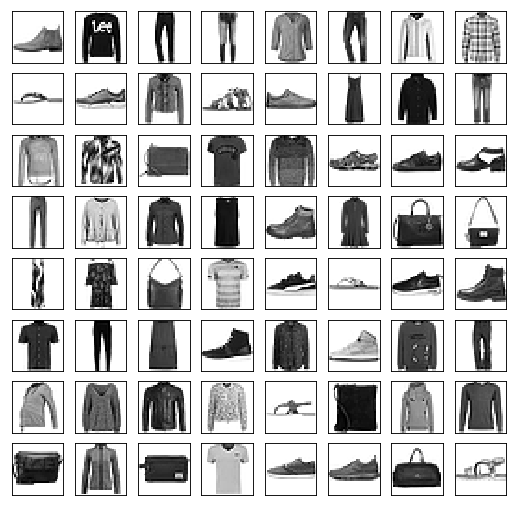

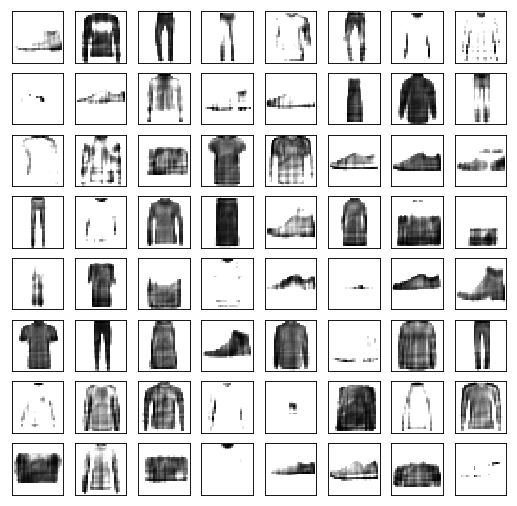

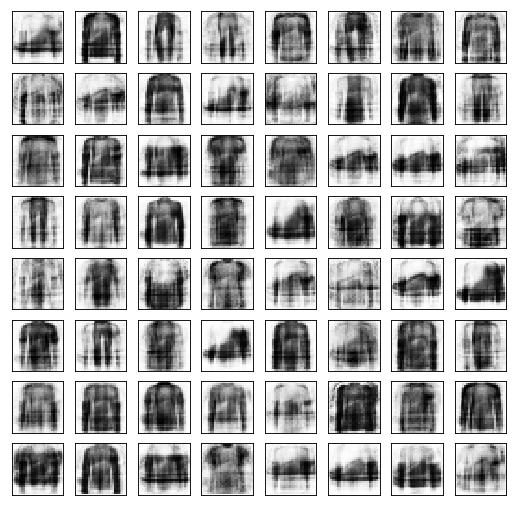

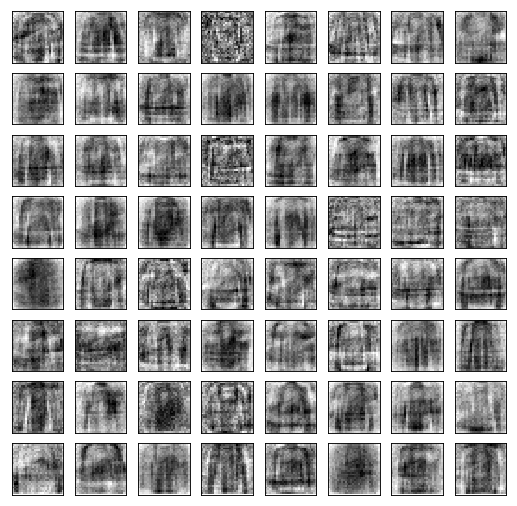

In [35]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

Используя дополнительный оптимайзер, подобрать на обученной сети картинку, на которой энкодер выдаст желаемый вектор латентного слоя и сравнить с тем что выдает декодер.

In [36]:
w, _ = next(iter(test_loader))
print(w.size())

torch.Size([64, 1, 28, 28])


In [37]:
w_optim = optim.Adam(params=[nn.Parameter(w)], lr=1e-2)

In [38]:
t = models["64"].E(w.view(-1, 28*28))
print(t.size())

torch.Size([64, 64])


In [39]:
loss = F.mse_loss(t, torch.eye(64))

In [40]:
models["64"](w).size()
# plot_mnist(dec_to_plot, (8, 8))

torch.Size([64, 784])

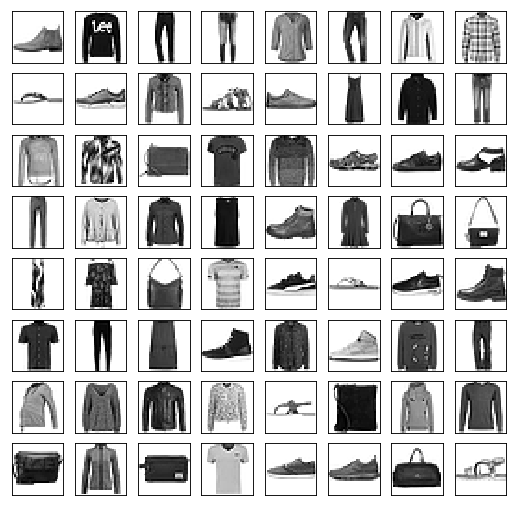

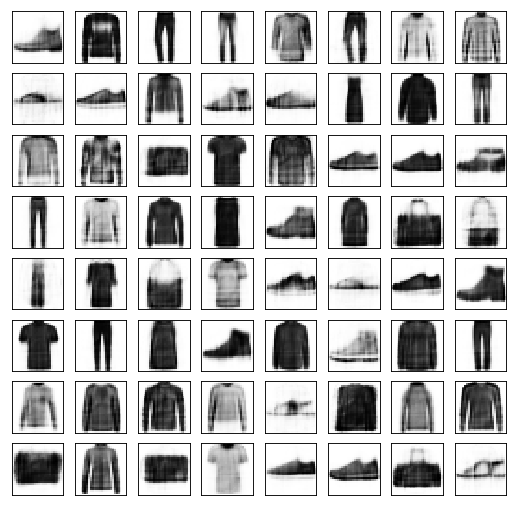

In [41]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(models["64"](w).view(-1, 1, 28, 28).data.numpy(), (8, 8))